# Epix10ka
Dark. Auto H to L, filter dac 1E, integration 50, no mask. CompEn 0, comp 010, TH dac 22, fel 1.

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [1]:
import h5py
import psana as pa
import Detector.PyDataAccess as pda
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
# import seaborn as sns

DPATH = "/reg/d/psdm/mfx/mfxx32516"
RUN = 370
 
# data file
dfile = h5py.File(DPATH + '/hdf5/smalldata/run_%d.h5' % (RUN), 'r')

epix10ka_active = []  # list to store current epix10ka cams in setup
for key,val in dict(dfile).iteritems():
    print key, val
    if "epix10ka" in key.lower():
        cam, idx = key.split("_")
        epix10ka_active.append(int(idx))

acqiris_0 <HDF5 group "/acqiris_0" (2 members)>
event_time <HDF5 dataset "event_time": shape (8802,), type "<i8">
fiducials <HDF5 dataset "fiducials": shape (8802,), type "<i8">
Epix10ka_0 <HDF5 group "/Epix10ka_0" (3 members)>
Epix10ka_1 <HDF5 group "/Epix10ka_1" (3 members)>
evr <HDF5 group "/evr" (2 members)>


Epix10ka_0


### [Epix10ka_0] RUN 370 config ###
R0Mode: 1
SyncDelay: 30
SyncMode: 0
SyncWidth: 30
acqToAsicR0Delay: 14032
adcClkHalfT: 1
adcPipelineDelay: 32
adcPipelineDelay0: 32
adcPipelineDelay1: 32
adcPipelineDelay2: 32
adcPipelineDelay3: 32
adcReadsPerPixel: 1
adcStreamMode: 0
analogCardId0: 3000428033
analogCardId1: 905969689
asicAcq: 0
asicAcqControl: 0
asicAcqLToPPmatL: 200
asicAcqWidth: 5000
asicGR: 0
asicGRControl: 0
asicMask: 15
asicPPmatToReadout: 0
asicPpbe: 0
asicPpbeControl: 0
asicPpmat: 1
asicPpmatControl: 1
asicR0: 0
asicR0ClkControl: 0
asicR0Control: 0
asicR0ToAsicAcq: 10000
asicR0Width: 30
asicRoClk: 0
asicRoClkHalfT: 5
asics_shape: [4]
baseClockFrequency: 1048576
calibPixelConfigArray: [[3 3 3 3 3 3 3 0 3 0 3 0 3 0 0 3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0
  3 3 0 3 3 3 3 0 3 3 0 3 0 3 3 0 3 3 0 0 3 0 0 3 0 0 0 3 3 3 0 0 0 0 3 0 3
  3 3 3 3 0 0 3 0 3 0 3 3 3 0 0 3 3 0 3 0 0 0 3 3 3 3 3 3 3 0 3 0 3 0 3 0 0
  3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0 3 3 0 3 3 

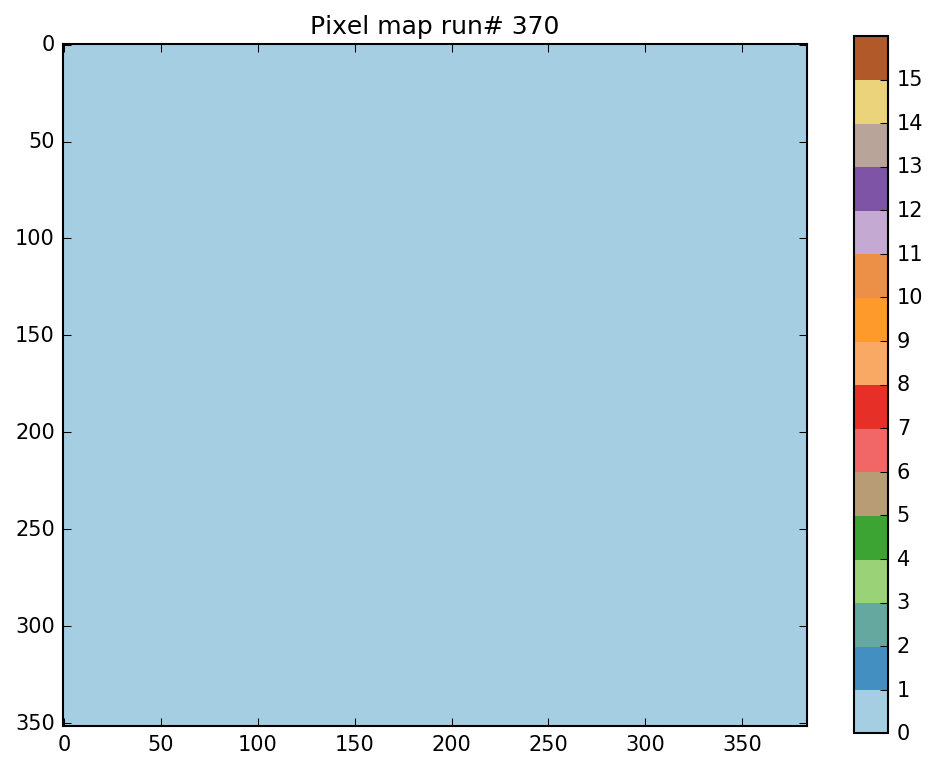

Epix10ka_1


### [Epix10ka_1] RUN 370 config ###
R0Mode: 1
SyncDelay: 30
SyncMode: 0
SyncWidth: 30
acqToAsicR0Delay: 14032
adcClkHalfT: 1
adcPipelineDelay: 32
adcPipelineDelay0: 32
adcPipelineDelay1: 32
adcPipelineDelay2: 32
adcPipelineDelay3: 32
adcReadsPerPixel: 1
adcStreamMode: 0
analogCardId0: 2996154369
analogCardId1: 218103833
asicAcq: 0
asicAcqControl: 0
asicAcqLToPPmatL: 200
asicAcqWidth: 5000
asicGR: 0
asicGRControl: 0
asicMask: 15
asicPPmatToReadout: 0
asicPpbe: 0
asicPpbeControl: 0
asicPpmat: 1
asicPpmatControl: 1
asicR0: 0
asicR0ClkControl: 0
asicR0Control: 0
asicR0ToAsicAcq: 10000
asicR0Width: 30
asicRoClk: 0
asicRoClkHalfT: 5
asics_shape: [4]
baseClockFrequency: 1048576
calibPixelConfigArray: [[3 3 3 3 3 3 3 0 3 0 3 0 3 0 0 3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0
  3 3 0 3 3 3 3 0 3 3 0 3 0 3 3 0 3 3 0 0 3 0 0 3 0 0 0 3 3 3 0 0 0 0 3 0 3
  3 3 3 3 0 0 3 0 3 0 3 3 3 0 0 3 3 0 3 0 0 0 3 3 3 3 3 3 3 0 3 0 3 0 3 0 0
  3 3 0 0 3 3 3 0 3 3 3 0 3 0 0 3 0 3 3 0 0 0 3 3 0 3 3 

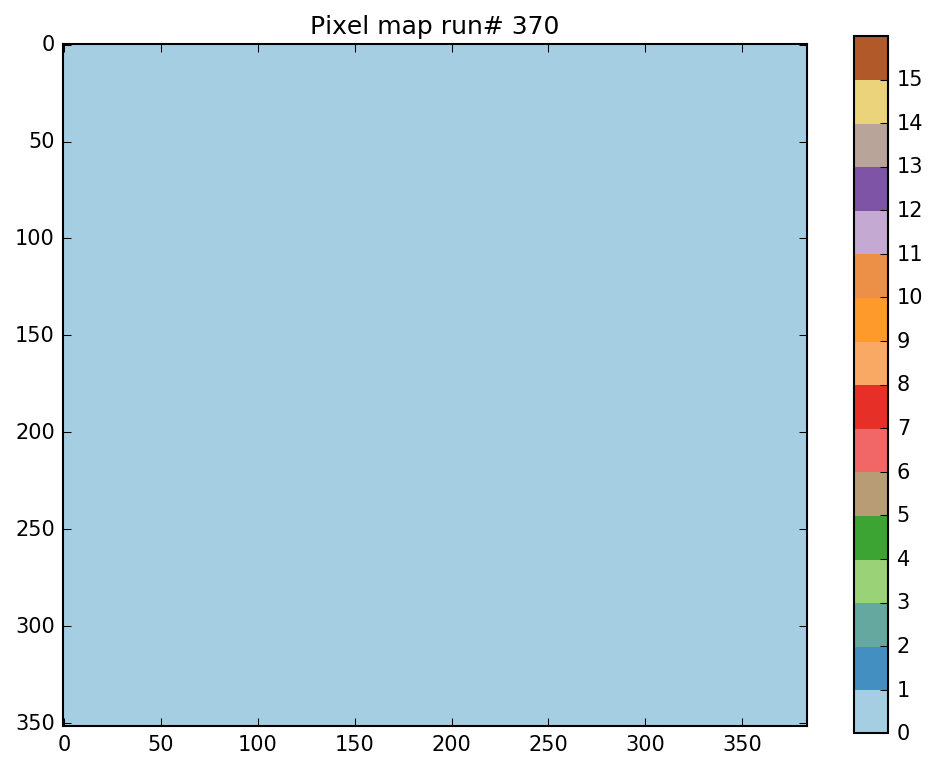

last two rows
Epix10ka_0:
(M=0) average calib row 176 (baseline) is 2393.746905, std is 159.417286
(M=0) average calib row 177 (pixelmax) is 16383.000000, std is 0.000000
(M=1) average calib row 177 (baseline) is 9272.635294, std is 6980.931411
(M=1) average calib row 176 (pixelmax) is 9529.095341, std is 6982.799418
Epix10ka_1:
(M=0) average calib row 176 (baseline) is 2413.849946, std is 174.625887
(M=0) average calib row 177 (pixelmax) is 16380.848844, std is 12.677564
(M=1) average calib row 177 (baseline) is 9140.240138, std is 6980.301506
(M=1) average calib row 176 (pixelmax) is 9653.188875, std is 6982.146488


In [40]:
import psana as pa
import Detector.PyDataAccess as pda
EXPSTR = 'exp=mfxx32516:run=%d:smd' % (RUN)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# calibPixelConfigArray
last2rows = []
ds = pa.DataSource(EXPSTR)
detNames = pa.DetNames()
for detname in detNames:
    sdet = detname[0].lower()
    if "epix10ka" in sdet:
        DETECTOR = detname[1]
        print(detname[1])
        src = pa.Source(DETECTOR)
        env = ds.env()
        config = env.configStore().get(pa.Epix.Config10kaV1, src)
        
        if not config:
            print('[%s] RUN %s, has no config\n\n' % (DETECTOR,RUN))
            postit = 0
        else:
            print('\n\n### [%s] RUN %s config ###' % (DETECTOR,RUN))
            for c in dir(config):
                # skip anything that starts with _
                if c[0] == "_":
                    continue
                # skip asics, we will traverse it later
                if c == "asics":
                    continue
                # get attr and check if it is callable
                v = getattr(config, c)
                if not callable(v):
                    continue
                # special cases
                if c.lower() == "asicPixelConfigArray".lower():
                    parr = v()
                    fig, ax = plt.subplots()
                    fig.set_dpi(150)
                    fig.set_size_inches(8, 6)
                    cax = ax.imshow(parr, vmin=0, vmax=16, cmap=discrete_cmap(16, 'Paired'))
                    ax.set_title('Pixel map run# %d' % (RUN))
                    cbar = fig.colorbar(cax, ticks=range(16))
                    cbar.ax.set_yticklabels(np.arange(0, 16, 1))
                    continue
                if c.lower() == "calibPixelConfigArray".lower():
                    last2rows.append(v())
            # print the value
                print("%s: %s" % (c, v()))

            for i in range(config.numberOfAsics()):
                print("\tasic%d:" % (i))
                aconf = config.asics(i)
                for c in dir(aconf):
                    if c[0] == "_":
                        continue
                    v = getattr(aconf, c)
                    if not callable(v):
                        continue
                    print("\t\t%s: %s" % (c, v()))
            plt.show()

# print("last two rows")
# asics = 4
# for idx, lrows in enumerate(last2rows):
#     # we will only check if the last two rows on all asics are equal.
#     print("Epix10ka_%d:" % (epix10ka_active[idx]))
#     if np.array_equal(lrows[0], lrows[1]):
#         epix10ka_calibd = dfile['/Epix10ka_%d/calib' % (epix10ka_active[idx])]
        
#         calib0 = np.argwhere(lrows[0] == 0).ravel()
#         calib1 = np.argwhere(np.bitwise_and(lrows[0],0x2) == 2).ravel()
#         for asic in np.arange(asics):
#             print("asic is %d" % (asic))
#             if asic == 0 or asic == 1:
#                 calib0_lim = calib0[np.argwhere(calib0 >= 192).ravel()]
#                 calib1_lim = calib1[np.argwhere(calib1 >= 192).ravel()]
#             else:
#                 calib0_lim = calib0[np.argwhere(calib0 < 192).ravel()]
#                 calib1_lim = calib1[np.argwhere(calib1 < 192).ravel()]
                
#             if asic == 0 or asic == 3:
#                 bl = 0
#                 mx = 2
#             else:        
#                 bl = 1
#                 mx = 3
                
#             calcol0_a_bl = epix10ka_calibd[:,bl,calib0_lim] & 0x3FFF # row 176 is baseline ASIC0&3
#             calcol0_a_mx = epix10ka_calibd[:,mx,calib0_lim] & 0x3FFF # row 177 is max
#             calcol1_a_mx = epix10ka_calibd[:,bl,calib1_lim] & 0x3FFF # rows are flipped
#             calcol1_a_bl = epix10ka_calibd[:,mx,calib1_lim] & 0x3FFF
            
#             print("(M=0) avg row 176 (baseline) is %f, std is %f" % (calcol0_a_bl.mean(), calcol0_a_bl.std()))
#             print("(M=0) avg row 177 (pixelmax) is %f, std is %f" % (calcol0_a_mx.mean(), calcol0_a_mx.std()))
#             print("(M=1) avg row 177 (baseline) is %f, std is %f" % (calcol1_a_bl.mean(), calcol1_a_bl.std()))
#             print("(M=1) avg row 176 (pixelmax) is %f, std is %f" % (calcol1_a_mx.mean(), calcol1_a_mx.std()))           
            
        
# #         calib0 = np.argwhere(lrows[0] == 0).ravel()
# #         calcol0_a0a3_bl = epix10ka_calibd[:,0,calib0] & 0x3FFF # row 176 is baseline ASIC0&3
# #         calcol0_a1a2_bl = epix10ka_calibd[:,1,calib0] & 0x3FFF # row 176 is baseline ASIC1&2
# #         calcol0_a0a3_mx = epix10ka_calibd[:,2,calib0] & 0x3FFF # row 177 is max
# #         calcol0_a1a2_mx = epix10ka_calibd[:,3,calib0] & 0x3FFF # row 177 is max

# #         calib1 = np.argwhere(np.bitwise_and(lrows[0],0x2) == 2).ravel()
# #         calcol1_a0a3_mx = epix10ka_calibd[:,0,calib1] & 0x3FFF # rows are flipped
# #         calcol1_a1a2_mx = epix10ka_calibd[:,1,calib1] & 0x3FFF
# #         calcol1_a0a3_bl = epix10ka_calibd[:,2,calib1] & 0x3FFF
# #         calcol1_a1a2_bl = epix10ka_calibd[:,3,calib1] & 0x3FFF
        
# #         calcol0_a0a3_bl_f = calcol0_a0a3_bl.ravel()
# #         calcol0_a1a2_bl_f = calcol0_a1a2_bl.ravel()
# #         calcol0_a0a3_mx_f = calcol0_a0a3_mx.ravel()
# #         calcol0_a1a2_mx_f = calcol0_a1a2_mx.ravel()
        
# #         calcol1_a0a3_bl_f = calcol1_a0a3_bl.ravel()
# #         calcol1_a1a2_bl_f = calcol1_a1a2_bl.ravel()
# #         calcol1_a0a3_mx_f = calcol1_a0a3_mx.ravel()
# #         calcol1_a1a2_mx_f = calcol1_a1a2_mx.ravel()
        
# #         print("(M=0) a0a3 calib row 176 (baseline) is %f, std is %f" % (calcol0_a0a3_bl_f.mean(), calcol0_a0a3_bl_f.std()))
# #         print("(M=0) a0a3 calib row 177 (pixelmax) is %f, std is %f" % (calcol0_a0a3_mx_f.mean(), calcol0_a0a3_mx_f.std()))
# #         print("(M=0) a1a2 calib row 176 (baseline) is %f, std is %f" % (calcol0_a1a2_bl_f.mean(), calcol0_a1a2_bl_f.std()))
# #         print("(M=0) a1a2 calib row 177 (pixelmax) is %f, std is %f" % (calcol0_a1a2_mx_f.mean(), calcol0_a1a2_mx_f.std()))

# #         print("(M=1) a0a3 calib row 177 (baseline) is %f, std is %f" % (calcol1_a0a3_bl_f.mean(), calcol1_a0a3_bl_f.std()))
# #         print("(M=1) a0a3 calib row 176 (pixelmax) is %f, std is %f" % (calcol1_a0a3_mx_f.mean(), calcol1_a0a3_mx_f.std()))
# #         print("(M=1) a1a2 calib row 177 (baseline) is %f, std is %f" % (calcol1_a1a2_bl_f.mean(), calcol1_a1a2_bl_f.std()))
# #         print("(M=1) a1a2 calib row 176 (pixelmax) is %f, std is %f" % (calcol1_a1a2_mx_f.mean(), calcol1_a1a2_mx_f.std()))
#     else:
#         print("TODO: row patterns are not equal")


print("last two rows")
for idx, lrows in enumerate(last2rows):
    # we will only check if the last two rows on all asics are equal.
    print("Epix10ka_%d:" % (epix10ka_active[idx]))
    if np.array_equal(lrows[0], lrows[1]):
        calib0 = np.argwhere(lrows[0] == 0).ravel()
        calib1 = np.argwhere(np.bitwise_and(lrows[0],0x2) == 2).ravel()
        
        epix10ka_calibd = dfile['/Epix10ka_%d/calib' % (epix10ka_active[idx])]
        calcol0_bl = epix10ka_calibd[:,0:1,calib0] & 0x3FFF # row 176 is baseline
        calcol0_mx = epix10ka_calibd[:,2:3,calib0] & 0x3FFF # row 177 is max
        
        calcol1_mx = epix10ka_calibd[:,0:1,calib1] & 0x3FFF # rows are flipped
        calcol1_bl = epix10ka_calibd[:,2:3,calib1] & 0x3FFF
        
        calcol0_bl_flat = calcol0_bl.ravel()
        calcol0_mx_flat = calcol0_mx.ravel()
        calcol1_bl_flat = calcol1_bl.ravel()
        calcol1_mx_flat = calcol1_mx.ravel()
        print("(M=0) average calib row 176 (baseline) is %f, std is %f" % (calcol0_bl_flat.mean(), calcol0_bl_flat.std()))
        print("(M=0) average calib row 177 (pixelmax) is %f, std is %f" % (calcol0_mx_flat.mean(), calcol0_mx_flat.std()))
        
        print("(M=1) average calib row 177 (baseline) is %f, std is %f" % (calcol1_bl_flat.mean(), calcol1_bl_flat.std()))
        print("(M=1) average calib row 176 (pixelmax) is %f, std is %f" % (calcol1_mx_flat.mean(), calcol1_mx_flat.std()))
    else:
        print("TODO: row patterns are not equal")

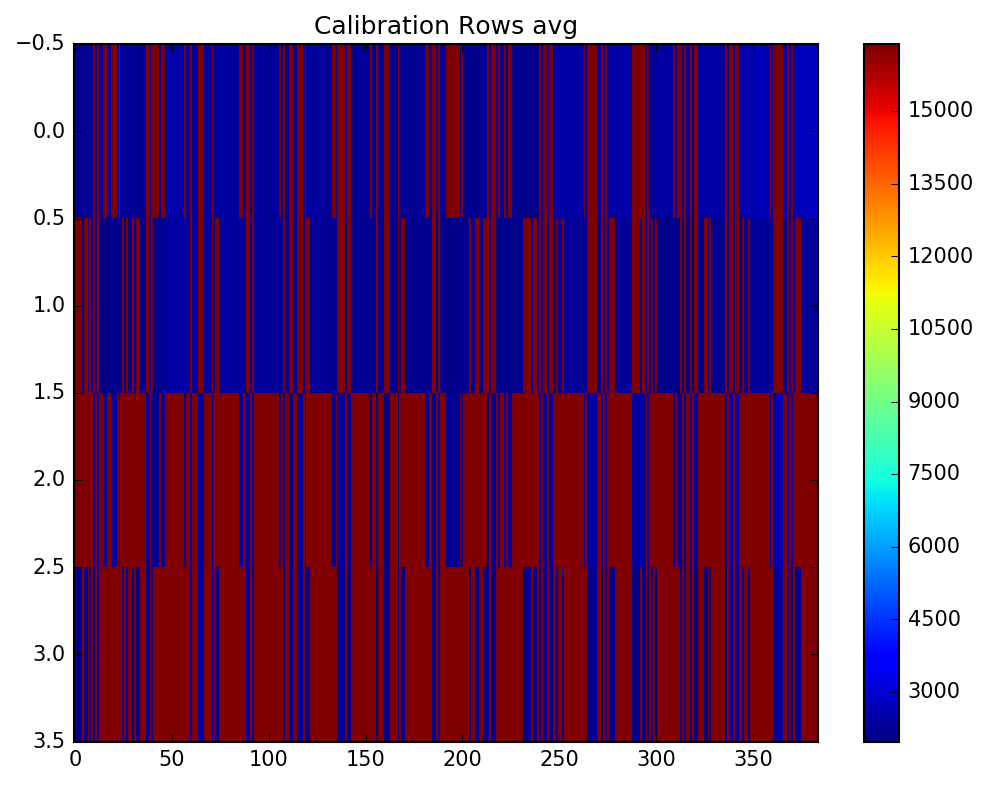

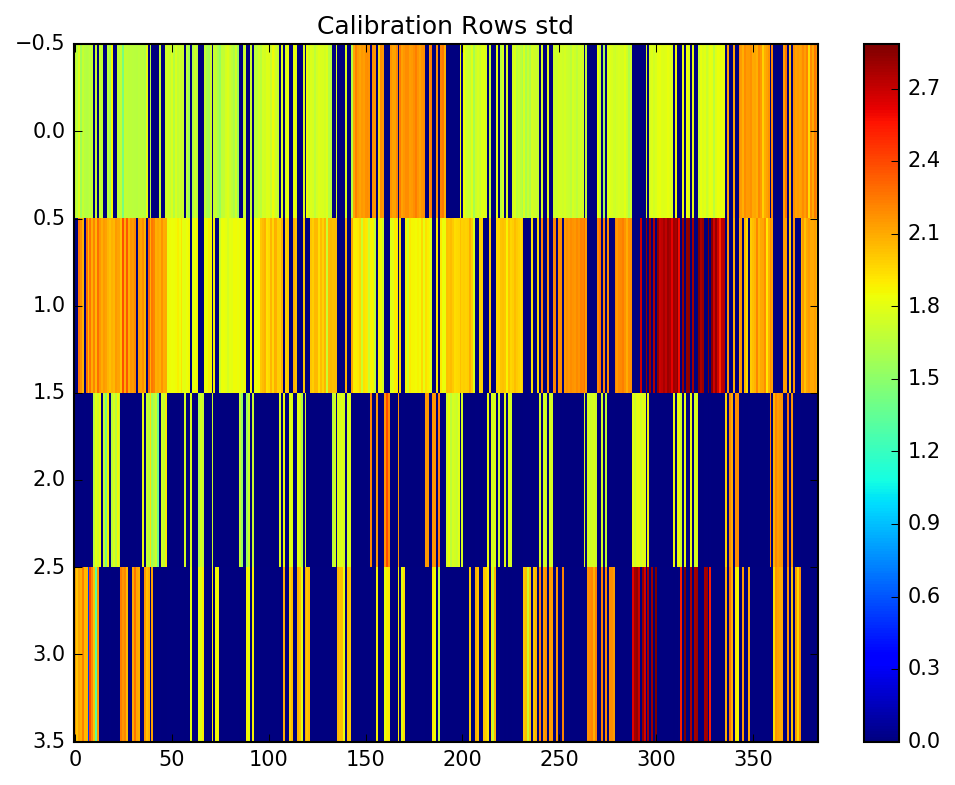

In [38]:
calibrows = epix10ka_calibd[:] & 0x3FFF

calibrows[:, 1, :] = np.roll(calibrows[:, 1, :], 48)
calibrows[:, 3, :] = np.roll(calibrows[:, 3, :], 48)

plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows avg')
plt.imshow(np.average(calibrows, 0), interpolation='none', aspect='auto')
plt.colorbar()
plt.show()


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows std')
plt.imshow(np.std(calibrows, 0), interpolation='none', aspect='auto')
plt.colorbar()
plt.show()

In [2]:
# epix10ka data
epix10ka_0_raw_f = dfile['/Epix10ka_0/raw']
epix10ka_0_env_f = dfile['/Epix10ka_0/env']
epix10ka_0_calib_f = dfile['/Epix10ka_0/calib']

print(epix10ka_0_raw_f.shape)
print(epix10ka_0_env_f.shape)
print(epix10ka_0_calib_f.shape)

epix10ka_1_raw_s = dfile['/Epix10ka_1/raw']
epix10ka_1_env_s = dfile['/Epix10ka_1/env']
epix10ka_1_calib_s = dfile['/Epix10ka_1/calib']

print(epix10ka_1_raw_s.shape)
print(epix10ka_1_env_s.shape)
print(epix10ka_1_calib_s.shape)

(8802, 352, 384)
(8802, 2, 192)
(8802, 4, 384)
(8802, 352, 384)
(8802, 2, 192)
(8802, 4, 384)


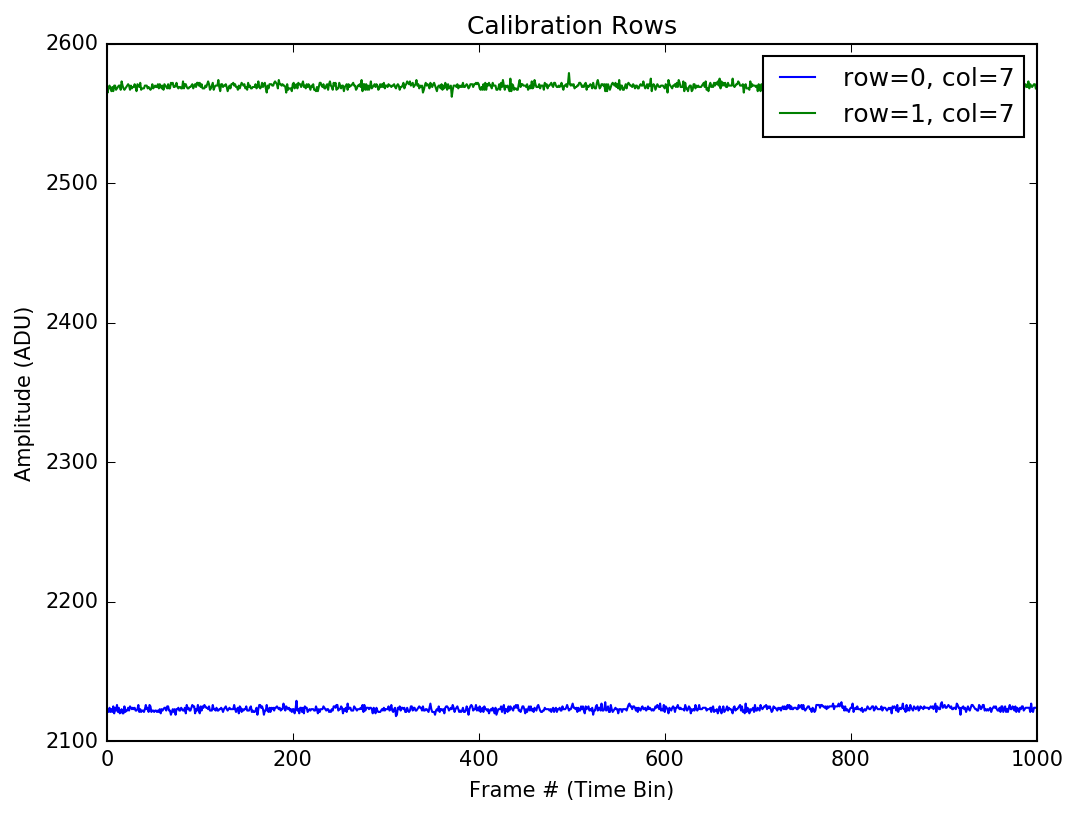

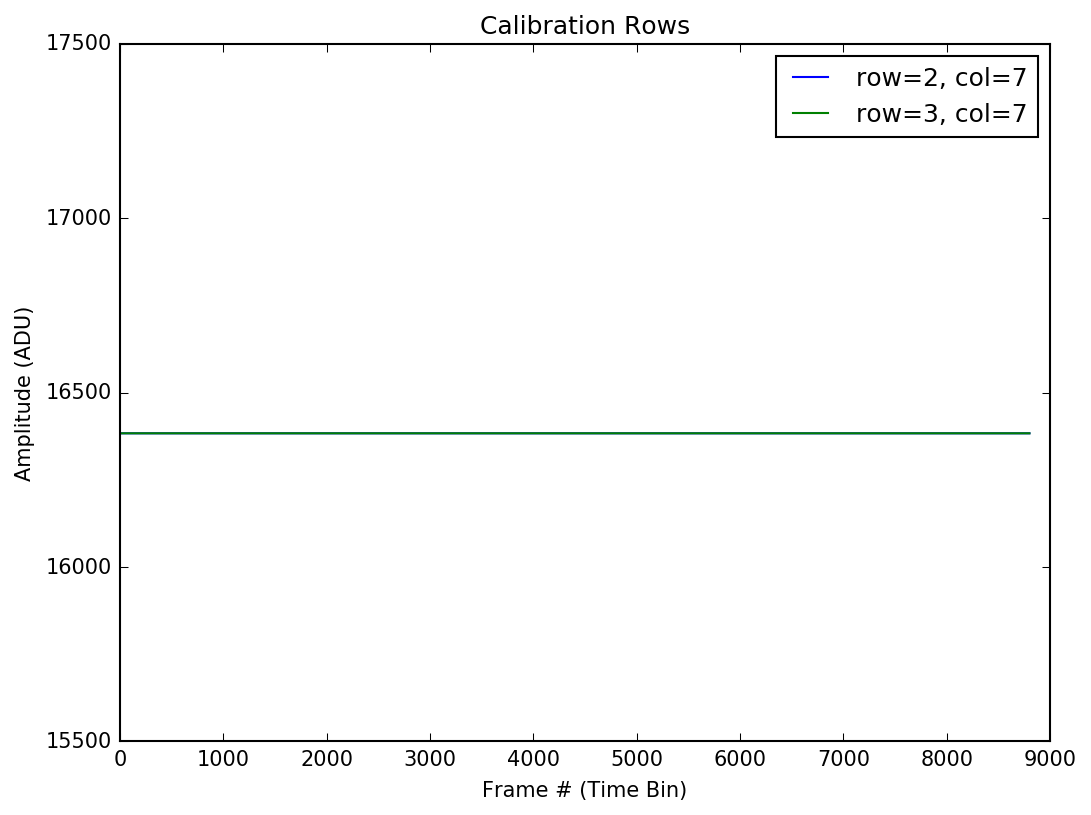

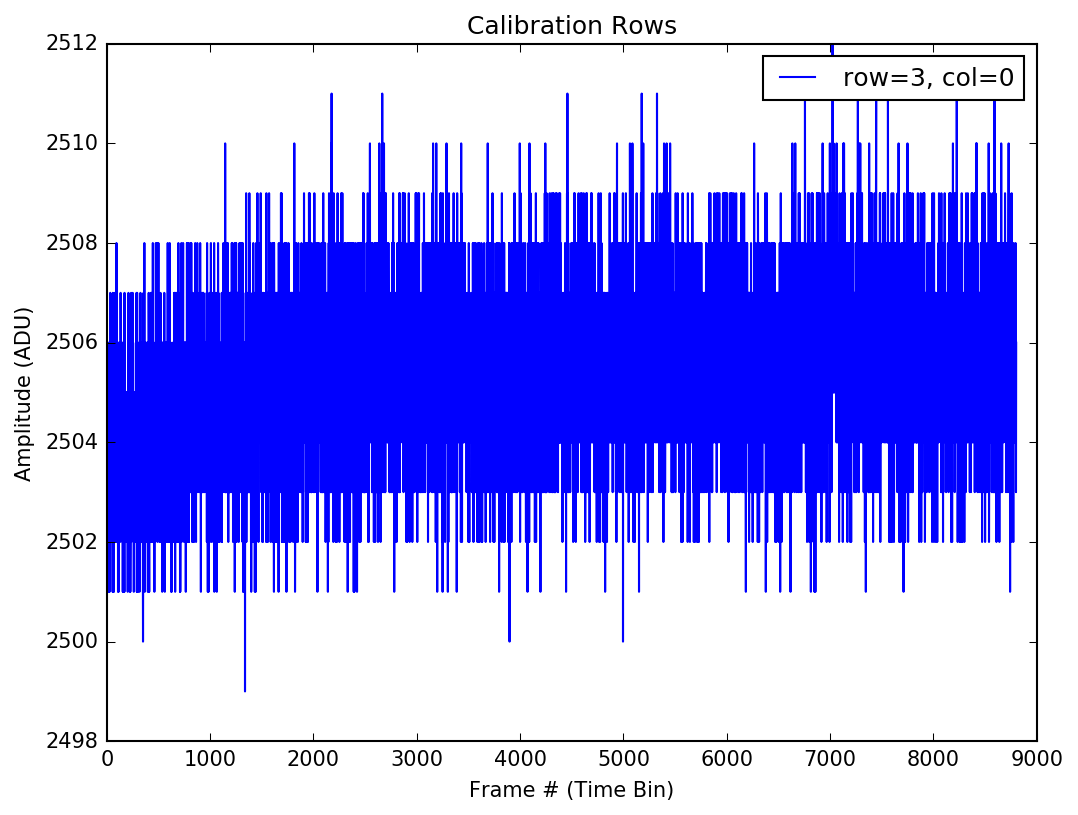

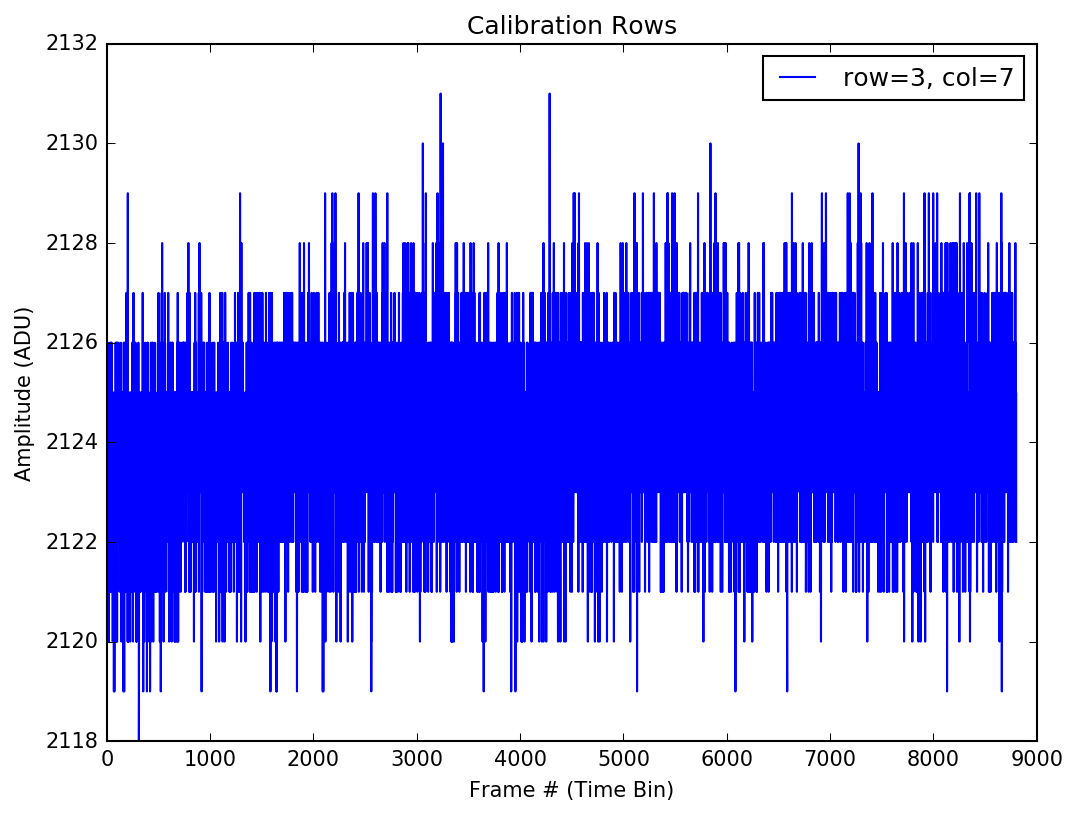

In [7]:
# calibration rows
# r0, r1, r2, r3

#|||||||||#
#¯¯¯¯|¯¯¯¯#
# A2 | A1 #
#----|----#
# A3 | A0 #
#____|____#
#|||||||||#

# r0 is row 176 in ASIC0 and ASIC3
# r1 is row 176 in ASIC1 and ASIC2

# r2 is row 177 (last) in ASIC0 and ASIC3
# r3 is row 177 (last) in ASIC1 and ASIC2

# when pixel (ga,ga,M,T) is xx0x then 176 is baseline and 177 is pixel max
# when pxiel (ga,ga,M,T) is xx1x then 176 is pixel max and 177 is baseline


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']
calcol = epix10ka_0_calib_f[:,:,7] & 0x3FFF
for idx, lbl in enumerate(labels):
    if idx == 0 or idx == 1:
        # print calcol[:, idx]
        # pass
        plt.plot(calcol[0:1000, idx] ,label=lbl + ', col=7')
    else:
        pass
        # plt.plot(calcol[:, idx] ,label=lbl + ', col=7')
plt.legend()
plt.show()


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']
calcol = epix10ka_0_calib_f[:,:,7] & 0x3FFF
for idx, lbl in enumerate(labels):
    if idx == 0 or idx == 1:
        # print calcol[:, idx]
        pass
        # plt.plot(calcol[0:1000, idx] ,label=lbl + ', col=7')
    else:
        # pass
        plt.plot(calcol[:, idx] ,label=lbl + ', col=7')
plt.legend()
plt.show()


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']
calcol0 = epix10ka_0_calib_f[:,0,0] & 0x3FFF
plt.plot(calcol0,label=lbl + ', col=0')
plt.legend()
plt.show()


plt.figure(1,figsize=(8,6),dpi=150)
plt.title('Calibration Rows')
plt.xlabel('Frame # (Time Bin)')
plt.ylabel('Amplitude (ADU)')
labels = ['row=0', 'row=1', 'row=2', 'row=3']
calcol7 = epix10ka_0_calib_f[:,0,7] & 0x3FFF
plt.plot(calcol7,label=lbl + ', col=7')
plt.legend()
plt.show()